In [1]:
#import various packages
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm 
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np 
from random import random, seed
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression

/Users/joergstihler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


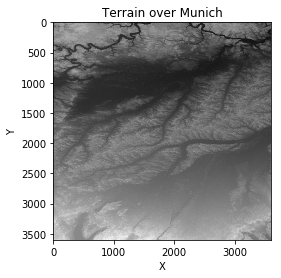

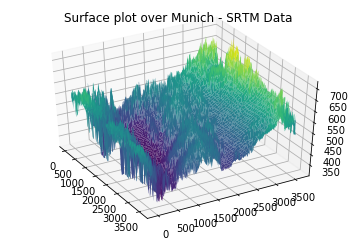

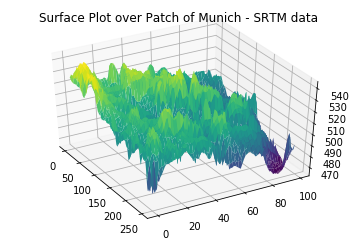

In [20]:
import numpy as np
from scipy.misc import imread
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from random import random, seed


def surface_plot(surface,title):
    M,N = surface.shape

    ax_rows = np.arange(M)
    ax_cols = np.arange(N)

    [X,Y] = np.meshgrid(ax_cols, ax_rows)

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.view_init(elev=40,azim=-30)
    ax.plot_surface(X,Y,surface,cmap=cm.viridis,linewidth=0)
    plt.title(title)

if __name__ == '__main__':

    # Load the terrain
    terrain1 = imread('SRTM_data_munich.tif')

    # Show the terrain
    plt.figure()
    plt.title('Terrain over Munich')
    plt.imshow(terrain1, cmap='gray')
    plt.xlabel('X')
    plt.ylabel('Y')

    surface_plot(terrain1,'Surface plot over Munich - SRTM Data')
   
    
    plt.show()

    # Extract a smaller patch of the terrain
    row_start = 1950
    row_end = 2050

    col_start = 1200
    col_end = 1450

    terrain1_patch = terrain1[row_start:row_end, col_start:col_end]

    surface_plot(terrain1_patch,'Surface Plot over Patch of Munich - SRTM data')
    

    plt.show()

    # Perform a OLS fitting using the whole axis pf the terrain data
    num_rows, num_cols = terrain1_patch.shape

    rows = np.arange(num_rows)
    cols = np.arange(num_cols)

    [C,R] = np.meshgrid(cols,rows)

    x = C.reshape(-1,1)
    y = R.reshape(-1,1)
    z = terrain1_patch.flatten()

#creating functions for the task

In [3]:
# function calculating the mean value of a given dataset (equivalent to the integrated mean function)

def samplemean(z):
    #input  : given outcome of experiment
    #output : mean value  
    length = len(z)
    samplemeann = 0
    for k in range(0,length):
        samplemeann = samplemeann+z[k]
        
    samplemeann = (1.0/len(z))*samplemeann
    return samplemeann

In [21]:
def centered(x):
    #input  : vector that should be centered
    #output : centered vector
    sm = samplemean(x)
    c=x-samplemean(x)
    
    return c
    

In [22]:
# centering the datasets
z_=z
intercept=samplemean(z)
x=centered(x)
y=centered(y)
z=centered(z)

In [23]:
# function that creates the designmatrix for two given input features

def designmatrix(x,y,degree):            
    #input1 : x-vector
    #input2 : y-vector
    #input3 : degree of polynomial for fit
    #output : Matrix X as defined in the lecture (in this particular case: up to degree 5 and mixed terms)
    
    lengthx = len(x)
    
    if degree == 5:
        X = np.c_[x,y,x**2,x*y,y**2, \
                  x**3, x**2*y, x*y**2, y**3, \
                  x**4, x**3*y, x**2*y**2, x*y**3,y**4, \
                  x**5, x**4*y, x**3*y**2, x**2*y**3,x*y**4, y**5]
            
    
    if degree == 4:
        X = np.c_[x,y,x**2,x*y,y**2, \
                  x**3, x**2*y, x*y**2, y**3, \
                  x**4, x**3*y, x**2*y**2, x*y**3,y**4]
           
            
    if degree == 3:
         X = np.c_[x,y,x**2,x*y,y**2, \
                  x**3, x**2*y, x*y**2, y**3]
                
            
    if degree == 2:
        X = np.c_[x,y,x**2,x*y,y**2]
            
           
    return X

In [24]:
# setting lamda to a test value lamda=1e-4 before cross validation
lamda = 0.001

In [8]:
#function that returns ridge regression coefficients for centered data

def betaridge(x,y,z,degree,lamda):             
    #input1 : indput data vector 1
    #input2 : indput data vector 2
    #input3 : target data vector
    #input4 : degree of polynomial for fit
    #input5 : chosen penalty
    #output : coefficients for polynomial fit of ridge regression
   
    #function for designmatrix is definded before (without the first columns consisting of ones)
    X = designmatrix(x,y,degree) 
    XtX = np.transpose(X).dot(X)
    ID = np.identity(XtX.shape[0])
    
    # Calculation of beta
    
    # intercept b[0] is calculated before as mean of target data
    betaridge0 = np.empty(1)                                                    
    betaridge0[0] = intercept                   
    betaridge2 = (np.linalg.inv(XtX+lamda*ID).dot(np.transpose(X))).dot(z)  # without b[0]
    betaridge=np.concatenate((betaridge0,betaridge2),axis=0)  

    return betaridge 

In [10]:
# function that predicts target values based on a model fitted to inputs x&y and true values z

def zpredict_f(x,y,z,degree,lamda):          
    #input1 : x-vector
    #input2 : y-vector
    #input3 : given observed data z
    #input4 : degree of polynomial for fit
    #output : predicted values with linear regression coefficients calculated with x,y
    
    X = np.c_[np.ones((len(x),1)),designmatrix(x,y,degree)]
    beta=betaridge(x,y,z,degree,lamda)
    
    zpredict = X.dot(beta)

    
    return zpredict

In [11]:
# function calculating the mean squared error 
def MSE(z,zpredict):
    #input1 : given outcome
    #input2 : predicted outcome
    #output : Mean Squared Error
    length = len(z)
    MSE = 0
    for j in range(0,length) :
        term = (z[j]-zpredict[j])**2
        MSE = MSE + term
    MSE = (1.0/length*MSE)
    return MSE

# function calculating the R^2 score
def R2score(z,zpredict):     
    #input1: given outcome of experiment
    #input2: predicted outcome of experiment
    #output: R2 score
    
    lengthz = len(z)
    sum1=0
    for k in range(0,lengthz):
        sum1=sum1+(z[k]-samplemean(z))**2
    
    R2score = 1 - ((MSE(z,zpredict)*lengthz)/(sum1))
    return R2score

# function that calculates an unbiased estimate of the variance according to Hastie et al. formula (3.8) p.47
def estvar(x,y,z,degree,lamda):                          
    #input1 : x-vector
    #input2 : y-vector
    #input3 : given outcome of experiment
    #input4 : degree of polynomial for fit
    #output : estimated variance
    p = np.array([6,10,15,21])
    p = p[degree-2]
    length = len(z)
    zpredictdeg = zpredict_f(x,y,z,degree,lamda)
    estvar = 0
    for k in range(0,length):
        estvar = estvar + (z_[k]-zpredictdeg[k])**2
    estvar=(1.0/(length-p-1))*estvar
    return estvar

# function calculating the variance of the ridge regression parameters
def betavariancer(x,y,z,degree,lamda):
    #input1 : x-vector
    #input2 : y-vector
    #input3 : given observed data z
    #input4 : degree of polynomial for fit
    #input5 : chosen penalty
    #output : coefficients for polynomial fit of ridge regression
   
    X = designmatrix(x,y,degree)
    XtX = np.transpose(X).dot(X)
    ID = np.identity(XtX.shape[0])
    Xlamdainvers = np.linalg.inv(XtX+lamda*ID) 
    betavariance=np.transpose(X).dot(z) 
    lengthb=len(betavariance)
    for k in range(0,lengthb):
        betavariance[k]=Xlamdainvers[k][k]*estvar(x,y,z,degree,lamda)
    
    return betavariance

In [ ]:
# warning: the following cell is only an overview and takes very long to compute. It can be of interest to skip this cell 

In [16]:
#Overview over degrees, coefficient size and variance

zpredict5 = zpredict_f(x,y,z,5,lamda)
MSE5 = MSE(z_,zpredict5)
R2score5 = R2score(z_,zpredict5)

zpredict4 = zpredict_f(x,y,z,4,lamda)
MSE4 = MSE(z_,zpredict4)
R2score4 = R2score(z_,zpredict4)

zpredict3 = zpredict_f(x,y,z,3,lamda)
MSE3 = MSE(z_,zpredict3)
R2score3 = R2score(z_,zpredict3)

zpredict2 = zpredict_f(x,y,z,2,lamda)
MSE2 = MSE(z_,zpredict2)
R2score2 = R2score(z_,zpredict2)


print('-----------------------------------------------------------------------------------')
print('Ridge overview: Lamda =', lamda)
print('')
print('degree2 ')
print('   MSE   : ',MSE2)
print('   R2    : ' ,R2score2)
print('degree3 ')
print('   MSE   : ',MSE3)
print('   R2    : ' ,R2score3)
print('degree4 ')
print('   MSE   : ',MSE4)
print('   R2    : ' ,R2score4)
print('degree5 ')
print('   MSE   : ',MSE5)
print('   R2    : ' ,R2score5)
print('')
print('Variance of the parameters beta - deg = 5')
np.set_printoptions(precision=6)
np.set_printoptions(suppress=True)
print('betaridge: ',betaridge(x,y,z,5,lamda))
print('Var(beta): ',betavariancer(x,y,z,5,lamda))
print('------------------------------------------------------------------------------------')



-----------------------------------------------------------------------------------
Ridge overview: Lamda = 0.001

degree2 
   MSE   :  86.95570168141292
   R2    :  0.5088258341110482
degree3 
   MSE   :  78.319135883667
   R2    :  0.5576099611990555
degree4 
   MSE   :  73.85950618608346
   R2    :  0.5828004300760655
degree5 
   MSE   :  65.79877386591652
   R2    :  0.6283319294171652

Confidence intervals of the parameters beta - deg = 5
betaridge:  [505.207     -0.066808   0.122155   0.001148   0.001333  -0.002652
   0.000004  -0.000078   0.000085  -0.000264  -0.        -0.
  -0.        -0.         0.        -0.         0.        -0.
   0.        -0.         0.      ]
Var(beta):  [0.000014 0.000089 0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.      ]
------------------------------------------------------------------------------------


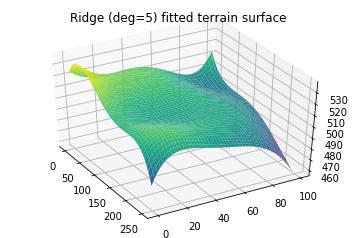

In [14]:
#testplot of the polynomial fit ridge regression degree 5, lamda
beta_ls=betaridge(x,y,z,5,lamda)
fitted_terrain = np.zeros((num_rows, num_cols))
for i in range(num_rows):
    y_ = rows[i]-samplemean(rows)
    for j in range(num_cols):
        x_ = cols[j]-samplemean(cols)

        data_vec = np.array([1, x_, y_, x_**2,x_*y_,y_**2 ,  \
                                x_**3, x_**2*y_, x_*y_**2, y_**3, \
                                x_**4, x_**3*y_,x_**2*y_**2, x_*y_**3,y_**4,   \
                                x_**5, x_**4*y_ ,x_**3*y_**2,x_**2*y_**3,x_*y_**4 ,y_**5])# \
                                #x_**6, x_**5*y_, x_**4*y_**2, x_**3*y_**3,x_**2*y_**4,x_*y_**5,y_**6, \
                                #x_**7, x_**6*y_, x_**5*y_**2, x_**4*y_**3,x_**3*y_**4,x_**2*y_**5,x_*y_**6,y_**7, \
                                #x_**8, x_**7*y_, x_**6*y_**2, x_**5*y_**3,x_**4*y_**4,x_**3*y_**5,x_**2*y_**6,x_*y_**7,y_**8, \
                                #x_**9, x_**8*y_, x_**7*y_**2, x_**6*y_**3,x_**5*y_**4,x_**4*y_**5,x_**3*y_**6,x_**2*y_**7,x_*y_**8,y_**9])
        fitted_terrain[i,j] = data_vec @ beta_ls
            

surface_plot(fitted_terrain,'Ridge (deg=5) fitted terrain surface')

plt.show()

In [17]:
# function predicting the test target values by applying the coefficients gained through the training data

def zpredict_cv(x,y,degree,beta):          
    #input1 : x-vector test
    #input2 : y-vector test
    #input3 : degree of polynomial for fit
    #input4 : beta from training
    #output : predicted values with linear regression coefficients calculated with xtrain,ytrain
    
    Xtrain = np.c_[np.ones((len(x),1)),designmatrix(x,y,degree)]
    zpredict = Xtrain.dot(beta)

    
    return zpredict

In [25]:
# k-crossvalidation, we choose k =10, that means we get 10 partitions
k=10

import random
#generating random partitions of our data 

#generating random order of data points
for j in range(0,len(z)):
    switchindex = random.choice(range(0,len(z)))
    switchvalueX = x[j]
    switchvalueY = y[j]
    switchvalueZ = z[j]
    switchvalueZ_= z_[j]
    x[j] =x[switchindex]
    y[j] =y[switchindex]
    z[j] =z[switchindex]
    z_[j]=z_[switchindex]
    x[switchindex] =switchvalueX
    y[switchindex] =switchvalueY
    z[switchindex] =switchvalueZ
    z_[switchindex]=switchvalueZ_

    
partitionsize = int(len(z)/k)
index = 0
lamdav=np.array([1e-5,1e-4,1e-3,0.01,0.1,1,10,1000])
lengthl=len(lamdav)
resultmatrixMSE=np.empty([k,lengthl])
resultmatrixR2=np.empty([k,lengthl])

mean_MSE_R2 = np.c_[(np.array(range(2,6))),np.zeros(4),np.zeros(4)]     #Matrix containing average MSE & R2 per degree
#making sure there are zeros in the matrix
for j in range(0,4):
    mean_MSE_R2[j][1]=0
    mean_MSE_R2[j][2]=0


partitionnumber = 1
for k in range(1,k+1):
    print('Partition ',partitionnumber)
    print()
    testx = x[index:index+partitionsize]                                #testdata
    testy = y[index:index+partitionsize]
    testz = z[index:index+partitionsize]
    testz_= z_[index:index+partitionsize]
    trainingx =  np.concatenate((x[:index],x[index+partitionsize:]))    #trainingdata
    trainingy =  np.concatenate((y[:index],y[index+partitionsize:]))
    trainingz =  np.concatenate((z[:index],z[index+partitionsize:]))
    trainingz_=  np.concatenate((z_[:index],z_[index+partitionsize:]))

    
    degree = 5
    print(' degree ',degree)
    for l in range(0,lengthl):
        betatrain = betaridge(trainingx,trainingy,trainingz,degree,lamdav[l])   #regression coefficients
    
        ztestpredict = zpredict_cv(testx,testy,degree,betatrain)                #predicting values for the testset
    
        MSEtest = MSE(testz_,ztestpredict)                                       #comparing predicted and real value
        R2scotest = R2score(testz_,ztestpredict)
        
        print('   lamda : ',lamdav[l])
        print('   MSE   : ',MSEtest)
        print('   R2    : ',R2scotest)
        
        resultmatrixMSE[k-1][l]=MSEtest
        resultmatrixR2[k-1][l]=R2scotest
        
    print()
    index = index+partitionsize
    partitionnumber += 1
    
    
print('----------------------------------------------------------------')
print()


Partition  1

 degree  5
   lamda :  1e-05
   MSE   :  156.8215321520008
   R2    :  0.07265791382493436
   lamda :  0.0001
   MSE   :  156.8215321519565
   R2    :  0.07265791382519637
   lamda :  0.001
   MSE   :  156.82153215151106
   R2    :  0.07265791382783027
   lamda :  0.01
   MSE   :  156.82153214705912
   R2    :  0.07265791385415621
   lamda :  0.1
   MSE   :  156.8215321025367
   R2    :  0.07265791411743316
   lamda :  1.0
   MSE   :  156.8215316573174
   R2    :  0.07265791675017508
   lamda :  10.0
   MSE   :  156.82152720524473
   R2    :  0.0726579430768809
   lamda :  1000.0
   MSE   :  156.82103883178635
   R2    :  0.07266083100467702

Partition  2

 degree  5
   lamda :  1e-05
   MSE   :  149.8564226921837
   R2    :  0.08401859473960849
   lamda :  0.0001
   MSE   :  149.8564226921399
   R2    :  0.08401859473987638
   lamda :  0.001
   MSE   :  149.8564226917044
   R2    :  0.08401859474253826
   lamda :  0.01
   MSE   :  149.85642268734946
   R2    :  0.0840185

In [26]:
# average MSE over all partitions per lamda
print(lamdav)
MSEmeanperlamda=np.empty([lengthl])
for k in range(0,lengthl):
    MSEmeanperlamda[k]=samplemean(resultmatrixMSE[:,k])
    
print(MSEmeanperlamda)

[   0.00001    0.0001     0.001      0.01       0.1        1.
   10.      1000.     ]
[162.955177 162.955177 162.955177 162.955177 162.955177 162.955177
 162.955177 162.955141]


In [27]:
# average R^2 over all partitions per lamda
R2meanperlamda=np.empty([lengthl])
for k in range(0,lengthl):
    R2meanperlamda[k]=samplemean(resultmatrixR2[:,k])
print(lamdav)    
print(R2meanperlamda)


[   0.00001    0.0001     0.001      0.01       0.1        1.
   10.      1000.     ]
[0.0769 0.0769 0.0769 0.0769 0.0769 0.0769 0.0769 0.0769]


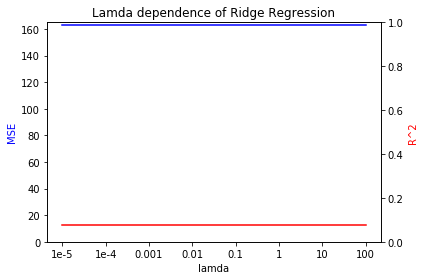

In [28]:
#Plot of lamda dependence of R^2 and MSE performance
lamdaaxis=np.array(range(1,lengthl+1))
fig, ax1 = plt.subplots()
plot =plt.plot()
plt.plot(lamdaaxis,MSEmeanperlamda,'b-')
plt.xticks(range(1,lengthl+1),('1e-5','1e-4','0.001','0.01','0.1','1','10','100','1000'))

plt.xlabel('lamda')
plt.ylabel('MSE', color='b')

ax1.set_ylim(0,165)

ay2 = plt.twinx()
ay2.plot(lamdaaxis,R2meanperlamda,'r-')
ay2.set_ylabel('R^2',color='r')
plt.title('Lamda dependence of Ridge Regression')
ay2.set_ylim(0, 1)


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [29]:
#control with sklearn

import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [30]:
xy=np.c_[x,y]
poly5 = PolynomialFeatures(degree=5)
XY = poly5.fit_transform(xy)
ridge5 = Ridge(alpha=lamda)
ridge5.fit(XY,z)
a=ridge5.intercept_
b=ridge5.coef_
b[0]=a
print('skl',b)
print('self',betaridge(x,y,z,5,lamda))

zpredict5_self=zpredict_f(x,y,z,5,lamda)
zpredict5_sk = ridge5.predict(XY)

MSE_self=MSE(z,zpredict5_self)
MSE_self2=mean_squared_error(z,zpredict5_self)
MSE_sk=mean_squared_error(z,zpredict5_sk)
R2_self=r2_score(z,zpredict5_self)
R2_sk=r2_score(z,zpredict5_sk)

print('MSE_self MSE   ',MSE_self)
print('MSE_self msesk ',MSE_self2)
print('MSE_sk         ',MSE_sk)
print('R2_self        ',R2_self)
print('R2_sk         ',R2_sk)

skl [ 1.196663 -0.025133  0.066525  0.000542  0.00049  -0.000017  0.000001
 -0.000044  0.000029 -0.000114 -0.       -0.       -0.       -0.
 -0.       -0.        0.        0.        0.       -0.        0.      ]
self [505.207     -0.024481   0.088984   0.000782   0.000461   0.001682
   0.000001  -0.000048   0.000029  -0.000146  -0.        -0.
  -0.        -0.        -0.000001  -0.         0.         0.
   0.        -0.         0.      ]
MSE_self MSE    255257.41050922143
MSE_self msesk  255257.41050922035
MSE_sk          163.92327686394054
R2_self         -1440.8358229479516
R2_sk          0.07407016185762316


/Users/joergstihler/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.399258e-28
  overwrite_a=True).T
